# Оптимизация расходов для металлургического  комбината ООО «Так закаляем сталь»

### Список вопросов Тимлиду:
1. Колличесво замеров температуры в разных партиях различное от 1 до 16. От сюда вопрос какую температуру нам нужно предсказать: первую, на каждом замере или последнею?
2. Не по всем партиям есть данные. Нужно сравнять колличесво партий, уменьшив количесво, или запониить пропуски?
3. Можно ли исклюдчить данные о подаче сыпучих материалов (время) и данные о проволочных материалах (время) из общей таблицы при обучение модели?


### План выполнения работы:
1. Предобработка данных (пропуски, аномалии)
    - пропуски, аномалии
    - добавить признаки:
        - полную мощность
        - продолжительность нагрева.
2. Объединение данных в одну таблицу по "key"
3. Обучить несколько моделей. 
4. Сравнить результаты и выбрать лучшую.


### Отчёт по работе:

1. **Какие пункты плана были выполнены, а какие — нет (поясните почему)?**
    - *в ходе работы выполнил все запланированные этапы*
2. **Какие трудности возникли и как вы их преодолели?**
    - *самый сложный этам - предобработка данных и формирование общей таблицы. решил с помощью свобных таблиц.*
3. **Какие ключевые шаги в решении задачи выделили?**
    - *Исследование данных, Предобработка, Подготовка данных, Построение моделей, Анализ результатов*
4. **Какая ваша итоговая модель и какое у неё качество?**
    - *CatBoostRegressor, модель показала хорошее качество 6.07.*

### Описание этапа обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

### Описание данных

Данные состоят из файлов, полученных из разных источников:

|Название файла|Описание|
|:-------|:--------|
|`data_arc.csv` |данные об электродах|
|`data_bulk.csv` | данные о подаче сыпучих материалов (объём)|
|`data_bulk_time.csv` | данные о подаче сыпучих материалов (время)|
|`data_gas.csv` | данные о продувке сплава газом|
|`data_temp.csv` | результаты измерения температуры|
|`data_wire.csv` | данные о проволочных материалах (объём)|
|`data_wire_time.csv` | данные о проволочных материалах (время)|

Во всех файлах столбец key содержит номер партии. В файлах может быть несколько строк с одинаковым значением key: они соответствуют разным итерациям обработки.

**Целевой признак:** последняя измеренная температура.

**Метрика:** MAE

**Критерии оценки:**
- MAE > 8.7 — 0 sp
- 7.6 < MAE ≤ 8.7 — 4 sp
- 6.8 < MAE ≤ 7.6 — 4.5 sp
- 6.3 < MAE ≤ 6.8 — 5 sp
- 6.0 < MAE ≤ 6.3 — 5.5 sp
- MAE ≤ 6.0 — 6 sp

## Содержание:
1. [Загрузка и исследование данных.](#load_data)
2. [Предобработка данных и формирование общей таблицы.](#step2)
3. [Обучение модели.](#step3)<br/>
    3.1. [CatBoostRegressor](#step3.1)<br/>
    3.2. [DecisionTreeRegressor](#step3.2)<br/>
    3.3. [RandomForestRegressor](#step3.3)<br/>
    3.4. [LGBMRegressor](#step3.4)<br/>
4. [Анализ результатов](#step4)

## 1. Загрузка и исследование данных. <a class="anchor" id="load_data"></a>

In [3]:
# импорт библиотек
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
from tqdm import notebook
from tqdm import tqdm
from datetime import date

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler

# модель
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

# метрика
from sklearn.metrics import mean_absolute_error

In [4]:
# чтение файла и печать общей информации
df_arc = pd.read_csv('data_arc.csv')
df_bulk = pd.read_csv('data_bulk.csv')
df_bulk_time = pd.read_csv('data_bulk_time.csv')
df_gas = pd.read_csv('data_gas.csv')
df_temp = pd.read_csv('data_temp.csv')
df_wire = pd.read_csv('data_wire.csv')
df_wire_time = pd.read_csv('data_wire_time.csv')

# данные об электродах
display(df_arc.head())
display(df_arc.info())

display(df_arc.isnull().sum())

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


None

key                     0
Начало нагрева дугой    0
Конец нагрева дугой     0
Активная мощность       0
Реактивная мощность     0
dtype: int64

В данных представлены время нагрева и **Активная и Реактивная мощности**. Думаю в дальнейшем потребуется рассчет **Полной мощности**

**Формула для расчета Полной мощности:**
$$
S=\sqrt{P^2+Q^2}
$$

где: 
- $P$ — активная мощность, 
- $Q$ — реактивная мощность 

In [5]:
# данные о подаче сыпучих материалов (объём)
display(df_bulk.head())
display(df_bulk.info())
display(df_bulk.isnull().sum())

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


None

key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64

In [6]:
# данные о подаче сыпучих материалов (время)
display(df_bulk_time.head())
display(df_bulk_time.info())


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


None

In [7]:
# данные о продувке сплава газом
display(df_gas.head())
display(df_gas.info())
display(df_gas.isnull().sum())

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


None

key      0
Газ 1    0
dtype: int64

In [8]:
# результаты измерения температуры
display(df_temp.head())
display(df_temp.info())
display(df_temp.isnull().sum())

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


None

key                0
Время замера       0
Температура     2901
dtype: int64

In [9]:
# функция для построения 2 графиков
def boxprint(colum, bins):
    print(colum.describe())
    q1 = colum.quantile(0.25)
    q3 = colum.quantile(0.75)
    iqr = q3 - q1
    colum.hist(bins=bins, range=((q1-1.5*iqr), (q3+3*iqr)))
    plt.show()
    sns.boxplot(x=colum, color='red')

count    13006.000000
mean      1591.840920
std         21.375851
min       1191.000000
25%       1581.000000
50%       1591.000000
75%       1601.000000
max       1705.000000
Name: Температура, dtype: float64


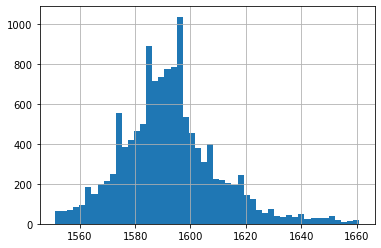

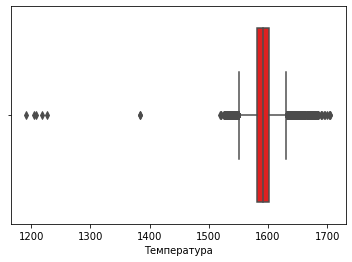

In [10]:
# посмотрим на распределение температур
boxprint(df_temp['Температура'], 50)

In [11]:
# посмотрим на выбросы
df_temp.query('Температура < 1500')

,key,Время замера,Температура
4350,867,2019-06-04 14:21:00,1191.0
5978,1214,2019-06-16 05:32:00,1208.0
7958,1619,2019-06-30 11:03:54,1218.0
8913,1818,2019-07-07 00:30:49,1383.0
8914,1818,2019-07-07 00:31:40,1383.0
10127,2052,2019-07-21 14:51:40,1227.0
12564,2561,2019-08-08 07:34:15,1204.0


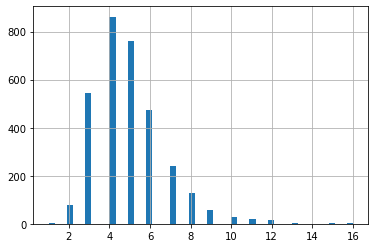

In [12]:
df_temp['key'].value_counts().hist(bins=50)

На графике видно, что подавляющее большенсво замеров находится в промежутке от 1500 до 1700 градусов, поэтому для лучшего качества модели удалим выбросы - замеры менее 1500 их всего 7 штук.

Также, колличесво замеров температуры различое на каждой партии различное, разброс от 1 до 16 при этом подавляющее большинсво находится в диапазоне от 2 до 10
.  

In [13]:
# данные о проволочных материалах (объём)
display(df_wire.head())
display(df_wire.info())

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


None

In [14]:
# данные о проволочных материалах (время)
display(df_wire_time.head())
display(df_wire_time.info())

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


None

В данных из таблиц `df_wire` и `df_wire_time`  присутвует множетво пропуском, вероятно это особенность процесса так как в процессе производсва используются не все примеси в каждом этапе, поэтому пропуски можно заменить на 0.

In [15]:
print('Данные об электродах', df_arc['key'].value_counts().shape[0])
print('Данные о подаче сыпучих материалов (объём)', df_bulk['key'].value_counts().shape[0])
print('Данные о подаче сыпучих материалов (время)', df_bulk_time['key'].value_counts().shape[0])
print('Данные о продувке сплава газом', df_gas['key'].value_counts().shape[0])
print('Результаты измерения температуры', df_temp['key'].value_counts().shape[0])
print('Данные о проволочных материалах (объём)', df_wire['key'].value_counts().shape[0])
print('Данные о проволочных материалах (время)', df_wire_time['key'].value_counts().shape[0])

Данные об электродах 3214
Данные о подаче сыпучих материалов (объём) 3129
Данные о подаче сыпучих материалов (время) 3129
Данные о продувке сплава газом 3239
Результаты измерения температуры 3216
Данные о проволочных материалах (объём) 3081
Данные о проволочных материалах (время) 3081


Не по всем партиям есть все данные. 

## 2. Предобработка данных и формирование общей таблицы. <a class="anchor" id="step2"></a>

#### Расчёт полной мощности и продолжительности нагрева дугой

In [16]:
# рассчитаем полную мощность
df_arc['Полная мощность'] = np.sqrt((np.array(df_arc['Активная мощность']) ** 2) + 
                                    (np.array(df_arc['Реактивная мощность']) ** 2)
                                   )

# рассчитаем продолжительность нагрева
df_arc['Начало нагрева дугой'] = pd.to_datetime(df_arc['Начало нагрева дугой'],
                                                format='%Y-%m-%dT%H:%M:%S')
df_arc['Конец нагрева дугой'] = pd.to_datetime(df_arc['Конец нагрева дугой'],
                                               format='%Y-%m-%dT%H:%M:%S')
df_arc['Время нагрева, секунд'] = ((df_arc['Конец нагрева дугой'] - df_arc['Начало нагрева дугой'])
                                   .dt.total_seconds()
                                   .astype(int)
                                  )
# уберем ненужные столбцы
data_arc_final=df_arc[['key', 'Время нагрева, секунд', 'Полная мощность']]
data_arc_final.head(3)

,key,"Время нагрева, секунд",Полная мощность
0,1,228,1.193639
1,1,185,0.959010
2,1,172,0.896038


#### Предобработка таблицы с Температурой.

In [17]:
# удалим выбросы
df_temp = df_temp.query('Температура >= 1450')

Партии, где только 1 замер температуры убираем так как нам нужен первый и последний. Для создадим новую таблицу с столбцами key и Колличество замером и затем присодиним к основной таблице и сделаем срез, чтобы убрать не нужные строки.

In [18]:
df_temp.groupby('key').count().head(3)

,Время замера,Температура
key,,
1,5,5
2,6,6
3,5,5


In [19]:
# создадим новый столбец
df_temp_count = df_temp.groupby('key').count()
df_temp_count['Количество_замеров'] = df_temp_count[['Температура']]
df_count_temp = df_temp_count[['Количество_замеров']]
display(df_count_temp.head())

# объединим таблицы
df_count_temp = df_count_temp.reset_index(drop=False)
df_temp = df_temp.merge(df_count_temp, on='key')
display(df_temp.tail(3))

,Количество_замеров
key,
1,5
2,6
3,5
4,3
5,2


,key,Время замера,Температура,Количество_замеров
12996,3239,2019-09-01 01:31:47,1598.0,1
12997,3240,2019-09-01 02:39:01,1617.0,1
12998,3241,2019-09-01 04:03:30,1586.0,1


In [20]:
# уберем партии с одним замером
df_temp = df_temp.query('Количество_замеров > 1')
display(df_temp.tail(3))

,key,Время замера,Температура,Количество_замеров
12258,2499,2019-08-06 02:40:25,1569.0,3
12259,2499,2019-08-06 02:54:24,1604.0,3
12260,2499,2019-08-06 03:00:28,1603.0,3


#### Формирование таблицы с первым и последним замером температуры

In [21]:
# создадим сводную таблицу с первым замером
data_temp_first = df_temp.pivot_table(index = ["key"],
                                      values = "Время замера", 
                                      aggfunc = "first")

data_temp_first = (data_temp_first
                   .merge(df_temp, on='Время замера')
                   .set_index('key')
                   .rename(columns={"Температура": "Первый_замер"})
                   .drop(['Время замера','Количество_замеров'] , axis=1)
                 )

# создадим сводную таблицу с последним замером
data_temp_last = df_temp.pivot_table(index = ["key"],
                                     values = "Время замера",
                                     aggfunc = "last")

data_temp_last = (data_temp_last.merge(df_temp, on='Время замера')
                  .set_index('key')
                  .rename(columns={"Температура": "Последний_замер"})
                  .drop(['Время замера','Количество_замеров'] , axis=1)
                 )

# объединим 2 таблицы
data_temp_final = data_temp_first.merge(data_temp_last, on='key')
display(data_temp_final)

,Первый_замер,Последний_замер
key,,
1,1571.0,1613.0
2,1581.0,1602.0
3,1596.0,1599.0
4,1601.0,1625.0
5,1576.0,1602.0
...,...,...
2495,1570.0,1591.0
2496,1554.0,1591.0
2497,1571.0,1589.0


Добавим к полученной таблицы данные по примесям и затраченной мощности.

In [22]:
#
final_data=data_temp_final.merge(data_arc_final, on='key')

final_data = (final_data
              .pivot_table(index = ['key', 'Первый_замер', 'Последний_замер'],
                                    values = ['Время нагрева, секунд', 'Полная мощность'],
                                    aggfunc = 'sum')
              .reset_index(drop=False)
              .set_index('key')
             )
final_data['Первый_замер'] = final_data['Первый_замер'].astype(int)
final_data['Последний_замер'] = final_data['Последний_замер'].astype(int)
display(final_data)

,Первый_замер,Последний_замер,"Время нагрева, секунд",Полная мощность
key,,,,
1,1571,1613,1098,5.826395
2,1581,1602,811,3.649216
3,1596,1599,655,2.989534
4,1601,1625,741,3.814962
5,1576,1602,869,4.035758
...,...,...,...,...
2495,1570,1591,723,3.986869
2496,1554,1591,940,5.057033
2497,1571,1589,569,2.885017


#### Предобработка таблицы с данными по газу.

In [23]:
#
final_data=(final_data
            .merge(df_gas, on='key')
            .set_index('key')
           )
display(final_data.head(1))

,Первый_замер,Последний_замер,"Время нагрева, секунд",Полная мощность,Газ 1
key,,,,,
1,1571,1613,1098,5.826395,29.749986


In [24]:
# запоним пропуски и объединим таблицы
df_wire=df_wire.fillna(0)
df_wire = df_wire.set_index('key')
final_data=final_data.merge(df_wire, on='key')
display(final_data.head(1))

,Первый_замер,Последний_замер,"Время нагрева, секунд",Полная мощность,Газ 1,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
key,,,,,,,,,,,,,,
1,1571,1613,1098,5.826395,29.749986,60.059998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### данные о подаче сыпучих материалов 

In [25]:
# запоним пропуски и объединим таблицы
df_bulk = df_bulk.fillna(0)
df_bulk = df_bulk.set_index('key')
final_data=final_data.merge(df_bulk, on='key')
display(final_data)

,Первый_замер,Последний_замер,"Время нагрева, секунд",Полная мощность,Газ 1,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,...,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
key,,,,,,,,,,,,,,,,,,,,,
1,1571,1613,1098,5.826395,29.749986,60.059998,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
2,1581,1602,811,3.649216,12.555561,96.052315,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
3,1596,1599,655,2.989534,28.554793,91.160157,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
4,1601,1625,741,3.814962,18.841219,89.063515,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
5,1576,1602,869,4.035758,5.413692,89.238236,9.11456,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,1570,1591,723,3.986869,7.125735,89.150879,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,90.0,0.0,256.0,0.0,129.0,223.0
2496,1554,1591,940,5.057033,9.412616,114.179527,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,122.0,0.0,256.0,0.0,129.0,226.0
2497,1571,1589,569,2.885017,6.271699,94.086723,9.04800,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,230.0,0.0,124.0,226.0


In [26]:
final_data.columns

Index(['Первый_замер', 'Последний_замер', 'Время нагрева, секунд',
       'Полная мощность', 'Газ 1', 'Wire 1', 'Wire 2', 'Wire 3', 'Wire 4',
       'Wire 5', 'Wire 6', 'Wire 7', 'Wire 8', 'Wire 9', 'Bulk 1', 'Bulk 2',
       'Bulk 3', 'Bulk 4', 'Bulk 5', 'Bulk 6', 'Bulk 7', 'Bulk 8', 'Bulk 9',
       'Bulk 10', 'Bulk 11', 'Bulk 12', 'Bulk 13', 'Bulk 14', 'Bulk 15'],
      dtype='object')

В результате слияния данных получилась таблица из 2329 строк и с 29 признаками.

## 3. Обучение модели. <a class="anchor" id="step3"></a>

In [27]:
# разбиение на подвыборки для кросс-валидации
kf = KFold(n_splits=5, shuffle=True, random_state=12345)

# словарь для результатов тесторвания
test_score = {}

In [28]:
# разделение на обучающие признаки и целевой
df_train, df_valid = train_test_split(final_data, test_size=0.20, random_state=12345)

features_train = df_train.drop(['Последний_замер'], axis=1).values
target_train = df_train['Последний_замер'].values

features_valid = df_valid.drop(['Последний_замер'], axis=1).values
target_valid = df_valid['Последний_замер'].values

### 3.1 CatBoostRegressor.<a class="anchor" id="step3.1"></a>

In [1]:
%%time
parameters = {'max_depth': np.arange(5, 7),
              'iterations': np.arange(400, 500, 100),
              'learning_rate': np.arange(0.02, 0.11, 0.03)
             }

gs = GridSearchCV(CatBoostRegressor(random_state=12345), 
                  parameters,
                  verbose = False,
                  cv=kf,
                  scoring='neg_mean_absolute_error')

# обучение
gs.fit(features_train, target_train)


NameError: name 'np' is not defined

In [30]:
# просмотр лучших параметров
display(gs.best_params_)

# лучший результат
display(gs.best_score_)

{'iterations': 400, 'learning_rate': 0.05, 'max_depth': 6}

-6.003868792775283

In [31]:
%%time
# обучение и проверка модели
modelCatBoost = (CatBoostRegressor(loss_function="MAE", iterations=400, learning_rate = 0.05,
                                  max_depth=6, verbose = False)
                .fit(features_train, target_train)
                )

train_predictions = modelCatBoost.predict(features_train)
valid_predictions = modelCatBoost.predict(features_valid)
mae_train_cb = mean_absolute_error(target_train, train_predictions)
mae_valid_cb = mean_absolute_error(target_valid, valid_predictions)
display("MAE_train:", mae_train_cb)
display("MAE_test:", mae_valid_cb)

'MAE_train:'

3.9751037743395954

'MAE_test:'

6.075949464678866

Wall time: 4.55 s


In [32]:
test_score['CatBoostRegressor'] = [mae_train_cb, mae_valid_cb, '8.26 s']

In [33]:
%%time
parameters = {'max_depth': np.arange(2, 25)}

gs = GridSearchCV(DecisionTreeRegressor(random_state=12345), 
                  parameters,
                  verbose = False,
                  cv=kf,
                  scoring='neg_mean_absolute_error')

# обучение
gs.fit(features_train, target_train)

# просмотр лучших параметров
display(gs.best_params_)

# лучший результат
display(gs.best_score_)

{'max_depth': 5}

-7.187310391265093

Wall time: 3.7 s


### 3.2. DecisionTreeRegressor <a class="anchor" id="step3.2"></a>

In [34]:
%%time
# обучение и проверка модели
model_dtr = (DecisionTreeRegressor(max_depth=5, random_state=12345)
                .fit(features_train, target_train)
                )

train_predictions = model_dtr.predict(features_train)
valid_predictions = model_dtr.predict(features_valid)
mae_train_dtr = mean_absolute_error(target_train, train_predictions)
mae_valid_dtr = mean_absolute_error(target_valid, valid_predictions)
display("MAE_train:", mae_train_dtr)
display("MAE_test:", mae_valid_dtr)

'MAE_train:'

6.04526747463125

'MAE_test:'

7.185275337778025

Wall time: 101 ms


In [35]:
test_score['DecisionTreeRegressor'] = [mae_train_dtr, mae_valid_dtr, '15.9 ms']

### 3.3. RandomForestRegressor <a class="anchor" id="step3.3"></a>

In [36]:
%%time
parameters = {'max_depth': np.arange(4, 7),
             'n_estimators': np.arange(2, 50)}

gs = GridSearchCV(RandomForestRegressor(random_state=12345), 
                  parameters,
                  verbose = False,
                  cv=kf,
                  scoring='neg_mean_absolute_error')

# обучение
gs.fit(features_train, target_train)

# просмотр лучших параметров
display(gs.best_params_)

# лучший результат
display(gs.best_score_)


{'max_depth': 6, 'n_estimators': 37}

-6.296275266657821

Wall time: 5min 40s


In [37]:
%%time
# обучение и проверка модели
rf_regr = (RandomForestRegressor(max_depth=6,
                                 n_estimators=37,
                                 random_state=12345
                                )
           .fit(features_train, target_train)
          )

train_predictions = rf_regr.predict(features_train)
valid_predictions = rf_regr.predict(features_valid)
mae_train_rf = mean_absolute_error(target_train, train_predictions)
mae_valid_rf = mean_absolute_error(target_valid, valid_predictions)
display("MAE_train:", mae_train_rf)
display("MAE_test:", mae_valid_rf)

'MAE_train:'

5.315209962236895

'MAE_test:'

6.477737214247355

Wall time: 1.14 s


In [38]:
test_score['RandomForestRegressor'] = [mae_train_rf, mae_valid_rf, '291 ms']

### 3.4 LGBMRegressor.  <a class="anchor" id="step3.4"></a>

In [39]:
%%time
parameters = {'max_depth': np.arange(2, 10),
             'n_estimators': np.arange(2, 50)}

gs = GridSearchCV(LGBMRegressor(random_state=12345), 
                  parameters,
                  verbose = False,
                  cv=kf,
                  scoring='neg_mean_absolute_error')

# обучение
gs.fit(features_train, target_train)

# просмотр лучших параметров
display(gs.best_params_)

# лучший результат
display(gs.best_score_)


{'max_depth': 8, 'n_estimators': 32}

-6.027887890998382

Wall time: 13min 7s


In [40]:
%%time
# обучение и проверка модели
model_lgb = (LGBMRegressor(max_depth=8, 
                           n_estimators=32,
                           random_state=12345)
             .fit(features_train, target_train)
            )

train_predictions = model_lgb.predict(features_train)
valid_predictions = model_lgb.predict(features_valid)
mae_train_lgb = mean_absolute_error(target_train, train_predictions)
mae_valid_lgb = mean_absolute_error(target_valid, valid_predictions)
display("MAE_train:", mae_train_lgb)
display("MAE_test:", mae_valid_lgb)

'MAE_train:'

4.5731480259810535

'MAE_test:'

6.189554238089524

Wall time: 1.42 s


In [41]:
test_score['LGBMRegressor'] = [mae_train_lgb, mae_valid_lgb, '591 ms']

## 4. Анализ результатов <a class="anchor" id="step4"></a>

,MAE_train,MAE_test,time
CatBoostRegressor,3.975104,6.075949,8.26 s
DecisionTreeRegressor,6.045267,7.185275,15.9 ms
RandomForestRegressor,5.315210,6.477737,291 ms
LGBMRegressor,4.573148,6.189554,591 ms


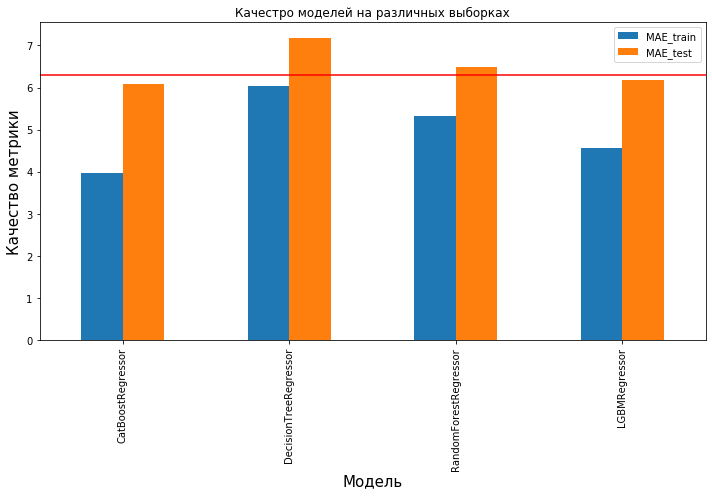

In [42]:
df_score = pd.DataFrame.from_dict(data=test_score, columns=['MAE_train', 'MAE_test', 'time'], orient='index')
display(df_score)

plt.figure(figsize=(10, 7))
plt.subplot(111)
df_score.plot(kind='bar', ax=plt.gca()).hlines(6.3, -1, 5,
                                              color = 'r')
plt.xlabel('Модель', fontsize=15)
plt.ylabel('Качество метрики', fontsize=15)
plt.title('Качестро моделей на различных выборках')

plt.tight_layout()

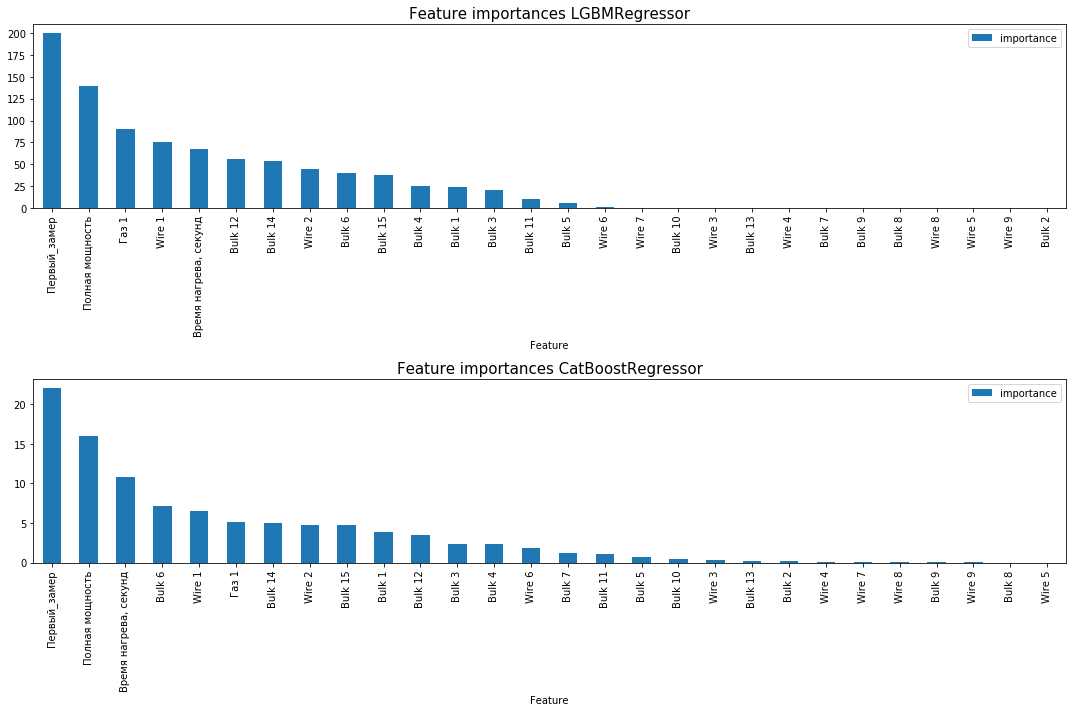

In [43]:
features = df_train.drop(['Последний_замер'], axis=1)
importanc_lgb = (pd.DataFrame({'feature': features.columns, 'importance': model_lgb.feature_importances_})
             .sort_values(by='importance', ascending=False)
            .reset_index()
            )

importanc_cb = (pd.DataFrame({'feature': features.columns, 'importance': modelCatBoost.feature_importances_})
             .sort_values(by='importance', ascending=False)
            .reset_index()
               )

                
plt.figure(figsize=(15, 10))

plt.subplot(211)           
importanc_lgb.plot(kind = 'bar', x='feature', y='importance', ax=plt.gca(), sharex=False)
plt.xlabel('Feature')
plt.title('Feature importances LGBMRegressor', fontsize=15)

plt.subplot(212)    
importanc_cb.plot(kind = 'bar', x='feature', y='importance', ax=plt.gca(), sharex=False)
plt.xlabel('Feature')
plt.title('Feature importances CatBoostRegressor', fontsize=15)

plt.tight_layout()

## 5. Выводы.

Для решения поставленной задачи я использовал 4 молели:
-  CatBoostRegressor,
- DecisionTreeRegressor
- RandomForestRegressor
- LGBMRegressor.

Хоршие результаты показали 2 модели:
- CatBoostRegressor MAE_test=6.09
- LGBMRegressor MAE_test=6.18

Разница в результатах не больная но стоит отметить, что LGBMRegressor рабоатет значительно быстрее, но точность лучше у CatBoostRegressor.
Для данной задачи высокая скорость прогноза не требуется, поэтому лучше использовать CatBoostRegressor

Также стоит обратить внимание, что для данных моделей важность признаков расположена в разном порядке, но Первый замер и Полная мощность имеюм вожное место в обоих моделях.